In [ ]:
import cv2
import numpy as np
from scipy.signal import medfilt
from IPython.display import Image, display

def bgr8_to_jpeg(value):
    return cv2.imencode('.jpg', value)[1].tobytes()

def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def iqr_filter(x_list):
    x = np.array(x_list)
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return [val for val in x if lower <= val <= upper]

def get_lane_midline_inner_edges_outlier_debug(image, debug_prefix='debug', apply_gamma=True):
    h, w = image.shape[:2]
    mid_x = w // 2

    if apply_gamma:
        image = adjust_gamma(image, gamma=1.2)

    # === Sobel X edges ===
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255 * sobelx / np.max(sobelx))
    _, sobel_bin = cv2.threshold(sobelx, 40, 255, cv2.THRESH_BINARY)

    sobel_mask = np.zeros_like(sobel_bin)
    sobel_mask[int(h * 0.45):, :] = sobel_bin[int(h * 0.45):, :]
    sobel_mask = cv2.morphologyEx(sobel_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

    # === HSV yellow mask ===
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv[..., 2] = cv2.equalizeHist(hsv[..., 2])
    mask_yellow = cv2.inRange(hsv, (10, 30, 40), (45, 255, 255))
    mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)
    yellow_sobel = cv2.bitwise_and(mask_yellow, sobel_mask)

    # === Extract left (yellow ∩ sobel) and right (sobel only) points ===
    left_pts = []
    right_pts = []

    contours, _ = cv2.findContours(sobel_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 20:
            continue
        for x, y in cnt[:, 0, :]:
            if y < int(h * 0.45):
                continue
            if x < mid_x and yellow_sobel[y, x] > 0:
                left_pts.append((x, y))
            elif x > mid_x:
                right_pts.append((x, y))

    # === Overlay image ===
    out_img = image.copy()
    if out_img.ndim == 2:
        out_img = cv2.cvtColor(out_img, cv2.COLOR_GRAY2BGR)

    mid_pts = []
    max_slope_deg = 30
    prev_xc, prev_y = None, None

    for y in range(int(h * 0.45), h, 4):
        x_lefts = [x for (x, yy) in left_pts if abs(yy - y) <= 2]
        x_rights = [x for (x, yy) in right_pts if abs(yy - y) <= 2]

        if len(x_lefts) >= 3:
            x_lefts = iqr_filter(x_lefts)
        if len(x_rights) >= 3:
            x_rights = iqr_filter(x_rights)

        if not x_lefts or not x_rights:
            continue

        x_left = max(x_lefts)
        x_right = min(x_rights)
        x_center = (x_left + x_right) // 2

        # Slope filtering
        if prev_xc is not None:
            dx = x_center - prev_xc
            dy = y - prev_y
            angle = np.degrees(np.arctan2(abs(dx), dy + 1e-5))
            if angle > max_slope_deg:
                continue

        mid_pts.append((x_center, y))
        prev_xc, prev_y = x_center, y

        # Draw edges
        cv2.circle(out_img, (int(x_left), int(y)), 2, (255, 0, 0), -1)
        cv2.circle(out_img, (int(x_right), int(y)), 2, (0, 0, 255), -1)

    # === Midline smoothing ===
    if mid_pts:
        x_vals = [x for x, y in mid_pts]
        x_smooth = medfilt(x_vals, kernel_size=5)
        mid_pts = list(zip(x_smooth, [y for _, y in mid_pts]))

    for x_c, y in mid_pts:
        cv2.circle(out_img, (int(x_c), int(y)), 2, (0, 255, 0), -1)

    # === Save debug outputs ===
    if debug_prefix:
        cv2.imwrite(f"{debug_prefix}_sobel.jpg", sobel_bin)
        cv2.imwrite(f"{debug_prefix}_yellow.jpg", mask_yellow)
        cv2.imwrite(f"{debug_prefix}_final_combined.jpg", sobel_mask)
        cv2.imwrite(f"{debug_prefix}_overlay.jpg", out_img)

    # === Deviation computation ===
    if mid_pts:
        x_center_last = mid_pts[-1][0]
        deviation = (x_center_last - mid_x) / mid_x
    else:
        deviation = 0.0

    return out_img, mid_pts, deviation


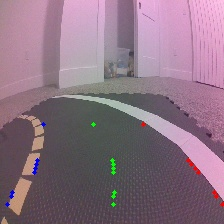

Deviation from center: 0.008928571428571428


In [ ]:
image = cv2.imread('Test_Lane_Images/image_5.jpg')
result_img, middle, deviation = get_lane_midline_inner_edges_outlier_debug(image)

display(Image(data=bgr8_to_jpeg(result_img)))
print("Deviation from center:", deviation)


In [ ]:
from jetbot import Robot, Camera, bgr8_to_jpeg
import cv2
import numpy as np
import ipywidgets as widgets
from IPython.display import display, Image, clear_output
import time

robot = Robot()
# Initialize our camera
camera = Camera.instance()

# Save image data (modified to be numpy array)
image = np.array(camera.value)

jpeg_image = bgr8_to_jpeg(image)

# Display image within Jupyter Notebook
display(Image(data=jpeg_image))

In [ ]:
import threading
image = widgets.Image(format='jpeg', width=300, height=300)
display(image)

def update_image():
    while True:
        img = camera.value
        out_img, dev = get_lane_midline_inner_edges_outlier_debug(img, None)
        image.value = bgr8_to_jpeg(out_img)
        display(dev)
        time.sleep(0.01)

threading.Thread(target=update_image, daemon=True).start()

In [ ]:
import cv2
import time
import threading
import numpy as np
import ipywidgets as widgets
from jetbot import Robot, Camera

# === PID controller class ===
class PIDController:
    def __init__(self, Kp=0.4, Kd=0.2):
        self.Kp = Kp
        self.Kd = Kd
        self.last_error = 0.0
        self.last_time = time.time()

    def compute(self, error):
        current_time = time.time()
        dt = current_time - self.last_time
        de = (error - self.last_error) / dt if dt > 0 else 0.0

        output = self.Kp * error + self.Kd * de

        self.last_error = error
        self.last_time = current_time
        return output

# === JetBot camera, robot, and PID setup ===
camera = Camera.instance(width=224, height=224)
robot = Robot()
pid = PIDController(Kp=0.004, Kd=0.00)

# === Display widgets ===
image_widget = widgets.Image(format='jpeg', width=300, height=300)
deviation_label = widgets.Label(value="Deviation: 0.00")
display(widgets.VBox([image_widget, deviation_label]))

# === Safe driving parameters ===
base_speed = 0.1  # forward throttle
max_turn = 0.04     # max allowed turn speed offset

# === Lane detection + control loop ===
def control_loop():
    while True:
        frame = camera.value  # RGB
        bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Run lane detection
        overlay, deviation = get_lane_midline_inner_edges_outlier_debug(
            bgr, debug_prefix=None, apply_gamma=True)

        # Compute turn from PID
        turn = pid.compute(deviation)

        # Scale turn safely
        turn = max(min(turn, max_turn), -max_turn)

        # Adjust left/right motor speeds
        left = base_speed + turn
        right = base_speed - turn

        # Clamp motor values
        left = max(min(left, 1.0), -1.0)
        right = max(min(right, 1.0), -1.0)

        robot.set_motors(left, right)

        # Update UI
        image_widget.value = bgr8_to_jpeg(overlay)
        deviation_label.value = f"Deviation: {deviation:+.2f}"

        time.sleep(0.05)  # ~20 FPS

# === Run in thread ===
threading.Thread(target=control_loop, daemon=True).start()


In [1]:
variable = 28
def test_function(num):
    return num + variable


print(test_function(-6))

22
